In [8]:
import ismrmrd
import rtoml
import os
import fnmatch
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
prewhiten = cfg['editer']['prewhiten']

data_dir_path = os.path.join(DATA_ROOT, DATA_DIR, 'raw/h5')
if raw_file.isnumeric():
    raw_file_ = fnmatch.filter(os.listdir(data_dir_path), f'meas_MID*{raw_file}*.h5')[0]
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file_)
    ismrmrd_noise_fullpath = os.path.join(DATA_ROOT, DATA_DIR, 'raw/noise', f'noise_{raw_file_}')
elif raw_file.startswith('meas_MID'):
    raw_file_ = raw_file
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file)
else:
    print('Could not find the file. Exiting...')
    exit(-1)


In [2]:
# Read the data in
print(f'Reading {ismrmrd_data_fullpath}...')
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = float(traj['param']['dt'])
msize = int(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']

# Convert raw data and trajectory into convenient arrays
ktraj = np.stack((kx, -ky), axis=2)
# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))
# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)
ktraj = 0.5 * (ktraj / kmax) * msize

data = [arm.data[:,:] for arm in acq_list]
dcf = np.tile(w[None, :], (n_acq, 1))
coord = [ktraj[ii%n_unique_angles,:,:] for ii in range(n_acq)]

data = np.array(data)
data = np.transpose(data, axes=(2, 0, 1))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(2, 1, 0))


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0902_20240611/raw/h5/meas_MID00175_FID15580_pulseq2D_fire_spiralga_400mV_24MHz.h5...
There are 14400 acquisitions in the file. Reading...
There are 4427 waveforms in the dataset. Reading...


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0902_20240611/raw/noise/noise_meas_MID00175_FID15580_pulseq2D_fire_spiralga_400mV_24MHz.h5...
There are 1842 acquisitions in the file. Reading...


Prewhitening the raw data...


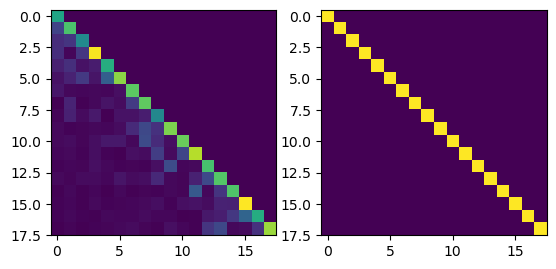

In [9]:
# Read the noise data in
print(f'Reading {ismrmrd_noise_fullpath}...')
with ismrmrd.Dataset(ismrmrd_noise_fullpath) as dset_noise:
    n_cal_acq = dset_noise.number_of_acquisitions()
    print(f'There are {n_cal_acq} acquisitions in the file. Reading...')

    cal_list = []
    for ii in range(n_cal_acq):
        cal_list.append(dset_noise.read_acquisition(ii))

noise_list = []

for cal_ in cal_list:
    if cal_.is_flag_set(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        noise_list.append(cal_.data)

noise = np.transpose(np.asarray(noise_list), (1,0,2)).reshape((noise_list[0].shape[0], -1))

if prewhiten:
    from reconstruction.coils import apply_prewhitening, calculate_prewhitening

    print('Prewhitening the raw data...')
    dmtx = calculate_prewhitening(noise)

    data = apply_prewhitening(np.transpose(data, (2,0,1)), dmtx).transpose((1,2,0))

    dmtx2 = calculate_prewhitening(apply_prewhitening(noise, dmtx))

    _,axs = plt.subplots(1,2)
    axs[0].imshow(np.abs(dmtx))
    axs[1].imshow(np.abs(dmtx2))
    plt.show()


In [3]:
%matplotlib widget
mri_coils = np.arange(15, dtype=int)
sensing_coils = np.array([15, 16, 17], dtype=int)
coil_name = []

# TODO: Automatic selection of coils by something like PT region energy vs k-space center energy

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)

print(f"Coils to be used as sniffers: {coil_name[sensing_coils.astype(int)]}")

f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

from scipy.signal.windows import tukey
ksp_window = tukey(data.shape[0]*2, 0.01)
ksp_window = ksp_window[data.shape[0]:, None, None]

ksp_measured = data[:,:,mri_coils]*ksp_window
ksp_sniffer  = data[:,:,sensing_coils]*ksp_window



/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Coils to be used as sniffers: ['Spine_18:1:S4T' 'Spine_18:1:S4S' 'Spine_18:1:S4P']


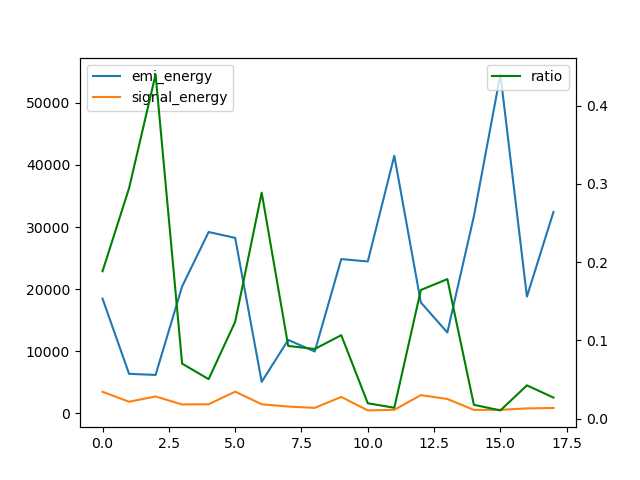

['Spine_18:1:S1T' 'Spine_18:1:S3T' 'Spine_18:1:S4T' 'Spine_18:1:S2T'
 'Spine_18:1:S4S' 'Spine_18:1:S4P' 'Spine_18:1:S2S' 'Spine_18:1:S1S'
 'Body_6:1:B21' 'Spine_18:1:S1P' 'Body_6:1:B13' 'Body_6:1:B12'
 'Spine_18:1:S3S' 'Spine_18:1:S2P' 'Body_6:1:B22' 'Spine_18:1:S3P'
 'Body_6:1:B11' 'Body_6:1:B23']
['Spine_18:1:S4T' 'Spine_18:1:S2T' 'Spine_18:1:S3T' 'Spine_18:1:S1T'
 'Spine_18:1:S4P' 'Spine_18:1:S4S' 'Body_6:1:B13' 'Body_6:1:B21'
 'Spine_18:1:S2S' 'Spine_18:1:S1S' 'Spine_18:1:S2P' 'Body_6:1:B23'
 'Spine_18:1:S3P' 'Spine_18:1:S3S' 'Body_6:1:B11' 'Spine_18:1:S1P'
 'Body_6:1:B12' 'Body_6:1:B22']
['Spine_18:1:S1T' 'Spine_18:1:S2T' 'Spine_18:1:S3T' 'Spine_18:1:S4T'
 'Spine_18:1:S4P']


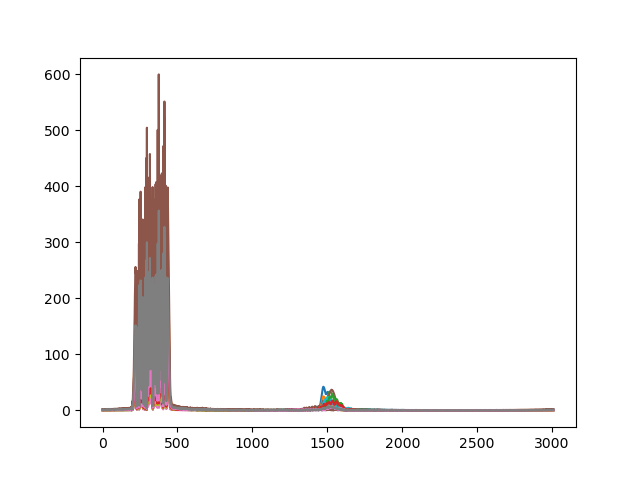

In [55]:
# TEST auto coil selection
from pilottone.pt import to_hybrid_kspace

f_pt = 24e6 # [Hz]
f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
f_diff = f0 - f_pt

f_samp  = 1/dt
n_samp = data2.shape[0]
df = f_samp/n_samp
freq_axis = np.arange(0, f_samp, df) - (f_samp - (n_samp % 2)*df)/2 # Handles both even and odd length signals.
signal_mask = (freq_axis < 100e3) & (freq_axis > -100e3)
signal_region = to_hybrid_kspace(data2[:, 0,:].squeeze())*signal_mask[:,None]

emi_mask = (freq_axis < (f_diff+50e3)) & (freq_axis > (f_diff-50e3))
emi_region = to_hybrid_kspace(data2[:, 0,:].squeeze())*emi_mask[:,None]

emi_energy = np.sum(np.abs(emi_region), axis=0)
signal_energy = np.sum(np.abs(signal_region), axis=0)
sratio = signal_energy/emi_energy

plt.figure()
plt.plot(np.abs(to_hybrid_kspace(data2[:,0,:].squeeze())))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(emi_energy, label='emi_energy')
ax1.plot(signal_energy, label='signal_energy')
ax1.legend()
ax2.plot(sratio, 'green', label='ratio')
ax2.legend()
plt.show()

Isig = np.argsort(signal_energy)
Irat = np.argsort(sratio)
print(coil_name[Isig])

print(coil_name[Irat])

print(coil_name[sratio < 0.03])
# plt.figure()
# plt.plot(np.abs(signal_region))
# plt.show()

# plt.figure()
# plt.plot(np.abs(emi_region))
# plt.show()

In [52]:
import numpy.typing as npt
import math
import scipy as sp

def get_noise_mtx(line_grp: npt.NDArray[np.complex64], dk: list[int]):
    """
    Creates the shifted noise matrix for a given line group and kernel sizes.

    Args:
        line_grp (numpy.ndarray): Line group data of shape (Nsamples, Nlines, Nchannels).
        dk (list or tuple): Kernel size [d_kx, d_ky].

    Returns:
        numpy.ndarray: Noise matrix of shape ((Nsamples * Nlines) x (Nchannels * (d_kx * 2 + 1) * (d_ky * 2 + 1))).
    """
    d_kx = dk[0]
    d_ky = dk[1]

    n_ch = line_grp.shape[2]

    # noise_mat = np.zeros((line_grp.shape[0], line_grp.shape[1], n_ch*(d_kx*2+1)*(d_ky*2+1)), dtype=line_grp.dtype)
    noise_mat = []

    dfp = np.pad(line_grp, ((d_kx, d_kx), (d_ky, d_ky), (0, 0)), mode='constant')
    if d_ky == 0:
        end_slc = None
    else:
        end_slc = d_ky
    ii = 0
    for col_shift in range(-d_kx, d_kx + 1):
        for lin_shift in range(-d_ky, d_ky + 1):
            dftmp = np.roll(dfp, shift=(col_shift, lin_shift), axis=(0, 1))
            cropped = dftmp[d_kx:-d_kx, d_ky:end_slc, :]
            # noise_mat[:,:,(ii*n_ch):((ii+1)*n_ch)] = dftmp[d_kx:-d_kx, d_ky:end_slc, :]
            ii += 1

            noise_mat.append(cropped)

    noise_mat = np.concatenate(noise_mat, axis=2)
    noise_mat = noise_mat.reshape(noise_mat.shape[0] * noise_mat.shape[1], -1)

    return noise_mat

def est_emi(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], line_grps: list[npt.NDArray], dk: list[int], w: npt.NDArray[np.float32]):

    Ncol, Nlin, Nc = sniffer.shape
    Ngrp = len(line_grps)
    emi_hat = np.zeros((Ncol, Nlin), dtype=np.complex64)
    kern = [] # np.zeros((Nc * (dk[0] * 2 + 1) * (dk[1] * 2 + 1), Ngrp))

    for cwin, pe_rng in enumerate(line_grps):
        # pe_rng is the range of lines in the current group
        noise_mat = get_noise_mtx(sniffer[:, pe_rng, :], dk)

        # Select grouped lines and flatten for inversion
        init_mat_sub = np.reshape(signal_in[:, pe_rng], (Ncol * len(pe_rng), 1))
        ww = np.reshape(w[:, pe_rng], (Ncol * len(pe_rng), 1))
        
        # Solving the linear system
        kern_ ,_,_,_ = sp.linalg.lstsq(ww * noise_mat, ww * init_mat_sub, cond=None, check_finite=False)
        kern.append(kern_)
        # Put the solution back
        emi_hat[:, pe_rng] = np.reshape(np.dot(noise_mat, kern_), (Ncol, len(pe_rng)))

    return emi_hat

def apply_editer(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], params, w) -> tuple[npt.NDArray[np.complex64], npt.NDArray[np.complex64]]:
    max_lines = params['max_lines_per_group']
    nlin = signal_in.shape[1]
    if params['grouping_method'] == "uniform":
        Ngrp = math.ceil(nlin/max_lines)
        line_grps = []

        for grp_i in range(Ngrp):
            line_grps.append(np.arange(((grp_i)*max_lines), min(max_lines*(grp_i+1), nlin)))


    emi_hat = est_emi(signal_in, sniffer, line_grps, params['dk'], w)
    return emi_hat
    


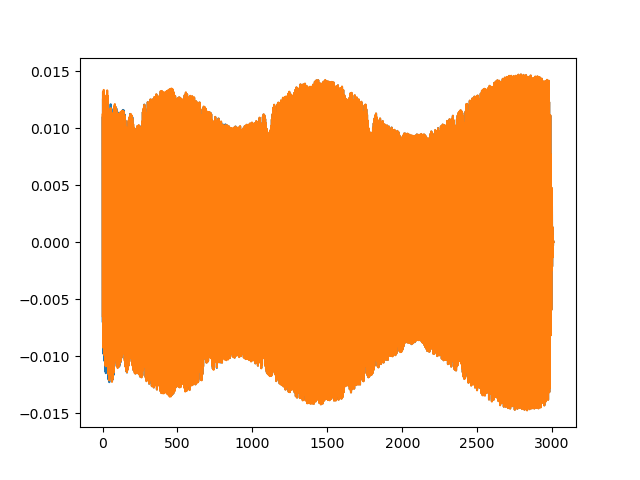

In [46]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd
U, S, V = svds(ksp_sniffer.reshape((ksp_sniffer.shape[0]*ksp_sniffer.shape[1], -1)), k=1)
ksp_sniffer2 = U*S*V
ksp_sniffer2 = ksp_sniffer2.reshape((ksp_sniffer.shape[0], ksp_sniffer.shape[1], ksp_sniffer.shape[2]))
plt.figure()
plt.plot(ksp_sniffer[:,0,0].squeeze())
plt.plot(ksp_sniffer2[:,0,0].squeeze())
plt.show()

In [37]:
from scipy.fftpack import fft, ifft
import time
import multiprocessing as mp

# ===============================================================
# Prepare EDITER weights and inputs
# ===============================================================
start_time = time.time()

# emi_hat = np.zeros(ksp_measured.shape, dtype=np.complex64)


dk = [3, 0]

w = np.concatenate((np.zeros((pre_discard, coord.shape[2])), np.sqrt(coord[0,:,:]**2 + coord[1,:,:]**2))).astype(np.float32)
n_pe = round(1000 / hdr.sequenceParameters.TR[0])  # 4 * Nlines / Nrep

editer_params = {
    'grouping_method': "uniform",  # "uniform", "corr_orig"
    'max_lines_per_group': n_pe,   # Max number of lines in a group
    'dk': dk                     # Convolution kernel size in kx and ky directions 
}

chs = range(ksp_measured.shape[2])

def process_channel(ch):
    return apply_editer(ksp_measured[:, :, ch], ksp_sniffer, editer_params, w)

with mp.Pool(processes=len(chs)) as pool:
    results = pool.map(process_channel, chs)

emi_hat = np.stack(results, axis=2)
ksp_emicorr = ksp_measured - emi_hat
# for ch_i in [0]:
#     ksp_emicorr[:, :, ch_i], _ = apply_editer(ksp_measured[:, :, ch_i], ksp_sniffer, editer_params, w)
# process_channel(0)
# for ch, result in enumerate(results):
#     ksp_emicorr[:, :, ch] = result

print(f"Elapsed time: {time.time() - start_time} seconds")

## TODO (IDEA): PCA sniffer coils before weighting and subtracting from k-space to "denoise" them. Compare SNR with and without.

Elapsed time: 171.49844336509705 seconds


## Profiler

In [14]:
%load_ext line_profiler
%lprun -u 1 -f est_emi apply_editer(ksp_measured[:, :, 0], ksp_sniffer, editer_params, w)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1 s

Total time: 32.7446 s
File: /tmp/ipykernel_2933227/772738164.py
Function: est_emi at line 44

Line #      Hits         Time  Per Hit   % Time  Line Contents
    44                                           def est_emi(signal_in: npt.NDArray[np.complex64], sniffer: npt.NDArray[np.complex64], line_grps: list[npt.NDArray], dk: list[int], w: npt.NDArray[np.float32]):
    45                                           
    46         1          0.0      0.0      0.0      Ncol, Nlin, Nc = sniffer.shape
    47         1          0.0      0.0      0.0      Ngrp = len(line_grps)
    48         1          0.0      0.0      0.0      emi_hat = np.zeros((Ncol, Nlin), dtype=np.complex64)
    49         1          0.0      0.0      0.0      kern = [] # np.zeros((Nc * (dk[0] * 2 + 1) * (dk[1] * 2 + 1), Ngrp))
    50                                           
    51        80          0.0      0.0      0.0      for cwin, pe_rng in enumerate(line_grps):
    52                             

/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


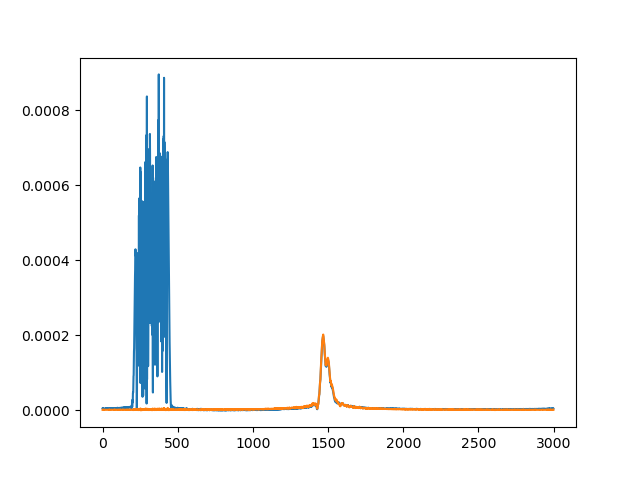

In [38]:
import pilottone as pt
plt.figure()
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_measured[pre_discard:,0,0])))
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_emicorr[pre_discard:,0,0])))

In [38]:
removeOS = True
Nsamp = ksp_emicorr.shape[0]
if removeOS:
    keepOS = np.concatenate([np.arange(Nsamp // 4), np.arange(Nsamp * 3 // 4, Nsamp)])
    ksp_emicorr = ifft(ksp_emicorr, axis=0)
    ksp_emicorr = fft(ksp_emicorr[keepOS, :, :], axis=0)
    Nsamp = Nsamp // 2